# Titanic Prediction

**In this Notebook, we try to predict whether a given passenger will survive the Titanic disaster or not.**

We are using *tensorflow* for performing the ML operations; *pandas* for dataset management; and *matplotlib* for plotting accuracy and loss curves.

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/titanic/titanic.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dataset Preparation

We drop the columns that we think are not useful in predicting whether a particular passenger will live or not.
Out of all these, *Cabin* might have been a useful feature, but as most of the values of *Cabin* are missing, we discard it as well as it would be of no particular use with all those missing values.

In [4]:
df.drop(columns = ["PassengerId", "Name", "Ticket", "Cabin"], inplace = True)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


We check how many missing values are present in the dataset. We need to remove them before training the model.

In [6]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

This gives the structure of our dataset.

In [7]:
df.shape

(891, 8)

The *age* feature has a significant number of missing values. We can just drop them but here, instead of droppin the examples with the missing values in *Age*, we are replacing them with the mean of the column.

In [8]:
mean = int(df["Age"].mean())
df["Age"] = df["Age"].fillna(mean)

In [9]:
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,29.0,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


At this point, we have only 2 missing values in *Embarked* feature. As it is very small, we can just discard the corresponding examples. After this, there are no more missing values in the dataset.

In [10]:
df = df.dropna()

The *Sex* feature has values in String. We can replace them as follows:
* Male: 1
* Female: 0

In [11]:
male_filter = df["Sex"] == "male"
female_filter = df["Sex"] == "female"

df.loc[male_filter, "Sex"] = 1
df.loc[female_filter, "Sex"] = 0

We have got quite a few catogorical features. We perform **One-Hot Encoding** on them to convert them into numeric values.

In [12]:
df = pd.get_dummies(df, columns = ["Pclass", "SibSp", "Parch", "Embarked"])

In [13]:
df.head()

,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,7.2500,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,1,0,38.0,71.2833,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0,26.0,7.9250,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,0,35.0,53.1000,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,35.0,8.0500,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


We convert all the Integer columns in the dataframe to Floats. This is because the neural network only works with floating point values.

In [14]:
for column in df:
    df[column] = df[column].astype(float)

Finally, we split the dataframe into 2 parts - one part contains only the features on which the model will train, and the other part contains the labels which the model will predict.

In [15]:
label = df["Survived"]
features = df.drop(columns = ["Survived"])

### Model Setup and Training

Although normalization of data is a data preparation task, we perform it within the model itself as a separate *preprocessing layer*. Here, we normalize all the features in the dataframe.

In [16]:
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(features)

We setup a Dense model and check the accuracy metric.

In [17]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(23, input_shape = [23]),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = "accuracy"
)

In [18]:
from ann_visualizer.visualize import ann_viz
import graphviz

graph = ann_viz(model, title = "Titanic Model")

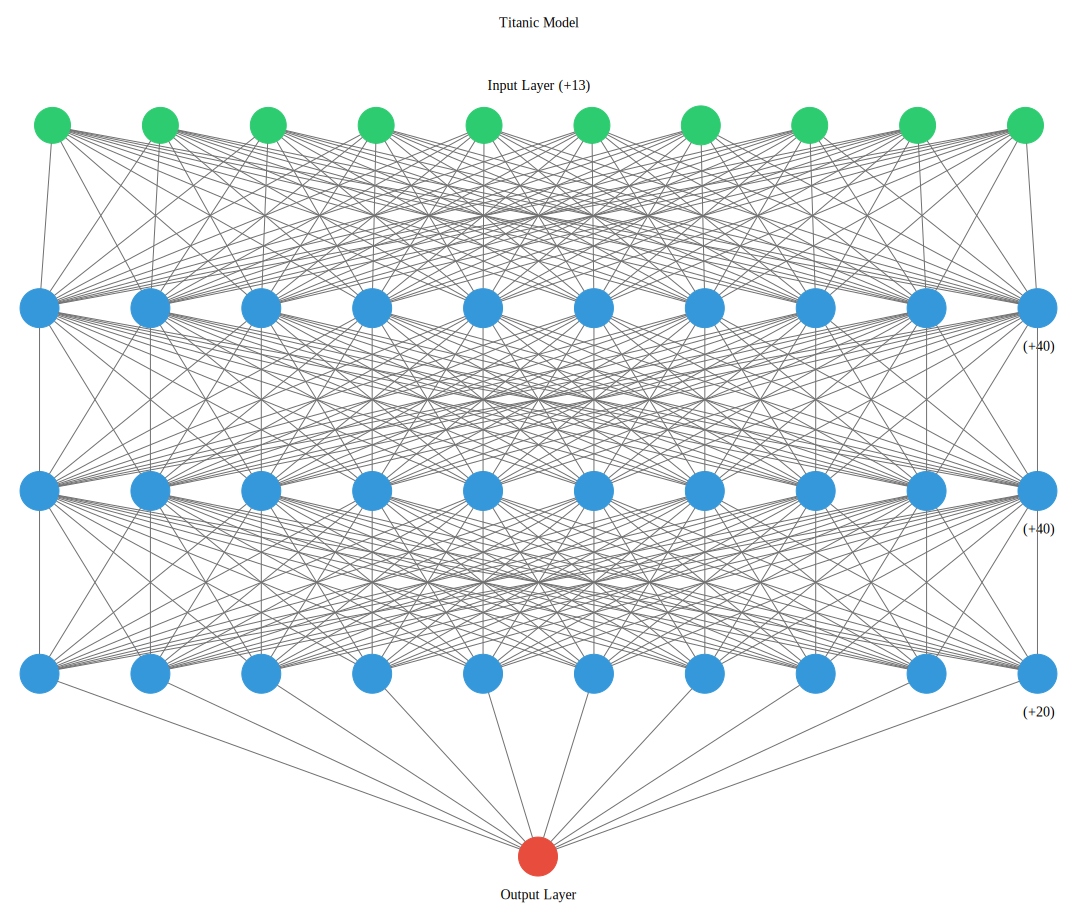

In [19]:
graph

We train the model for the set number of epochs. While doing so, we also specify a validation set which will be used to validate the correctness of the model during training.

In [48]:
history = model.fit(features, label, validation_split = 0.2, epochs = 50)

Epoch 1/50
23/23 [==============================] - 1s 14ms/step - loss: 0.9564 - accuracy: 0.6203 - val_loss: 0.8503 - val_accuracy: 0.7247
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6507 - accuracy: 0.7004 - val_loss: 0.5038 - val_accuracy: 0.7753
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 0.5083 - accuracy: 0.7722 - val_loss: 0.4275 - val_accuracy: 0.7978
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.4776 - accuracy: 0.7932 - val_loss: 0.4012 - val_accuracy: 0.8315
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.4527 - accuracy: 0.7961 - val_loss: 0.3866 - val_accuracy: 0.8539
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.4706 - accuracy: 0.8017 - val_loss: 0.3725 - val_accuracy: 0.8427
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 0.4570 - accuracy: 0.8045 - val_loss: 0.3745 - val_accuracy: 0.8427
Epoch 8/50
23/23 [=

Finally, we plot the *loss* and *accuracy* curves.

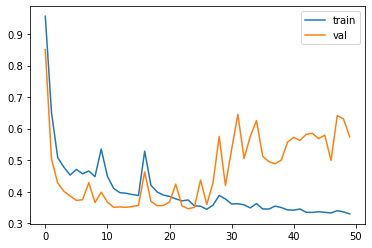

In [49]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "val"])
plt.show()

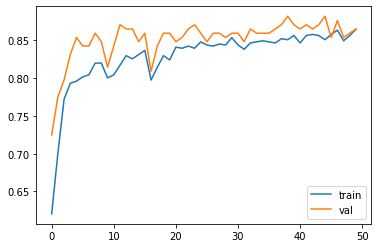

In [50]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "val"])
plt.show()

### Results

After running above 10 iterations, the following data has been observed:

| Iteration | Training Accuracy | Validation Accuracy |
| --------- | ----------------- | ------------------- |
| 1         | 86.50%            | 84.27%              |
| 2         | 80.59%            | 80.90%              |
| 3         | 86.22%            | 84.27%              |
| 4         | 87.06%            | 83.71%              |
| 5         | 88.19%            | 81.46%              |
| 6         | 87.06%            | 82.58%              |
| 7         | 86.08%            | 83.71%              |
| 8         | 81.01%            | 80.90%              |
| 9         | 83.40%            | 80.34%              |
| 10        | 86.50%            | 86.52%              |

**Average Training Accuracy: 85.26%**

**Average Validation Accuracy: 85.27%**